In [32]:
!pip install noisereduce

In [33]:
# Import libraries
import os
import zipfile
import pathlib
import shutil
import numpy as np
import librosa
import librosa.display
import noisereduce as nr
import tensorflow as tf
from sklearn.utils import resample
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.image import resize

In [34]:
# Step 1: Unzip the dataset
!unzip -t dataset.zip

with zipfile.ZipFile('dataset.zip', 'r') as z:
    z.extractall()

Archive:  dataset.zip
    testing: donateacry_corpus/belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav   OK
    testing: donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138495-1.0-m-72-bp.wav   OK
    testing: donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138506-1.0-m-72-bp.wav   OK
    testing: donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav   OK
    testing: donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138524-1.0-m-72-bp.wav   OK
    testing: donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138536-1.0-m-72-bp.wav   OK
    testing: donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138545-1.0-m-72-bp.wav   OK
    testing: donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp.wav   OK
    testing: donateacry_corpus/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-14301386

In [35]:
# Step 2: Define folder structure
input_dataset_path = 'donateacry_corpus'
classes = np.array(tf.io.gfile.listdir(str(input_dataset_path)))
print("Classes found: ", classes)

Classes found:  ['hungry' 'tired' 'belly_pain' 'burping' 'discomfort']


In [36]:
# Initialize paths and other settings
n_mfcc = 13
desired_labels = ['hungry', 'discomfort', 'belly_pain', 'burping', 'tired']
class_files = {cry: list((pathlib.Path(input_dataset_path) / cry).glob('*.wav')) for cry in desired_labels}
class_counts = {cry: len(files) for cry, files in class_files.items()}
print("Class counts: ", class_counts)

Class counts:  {'hungry': 382, 'discomfort': 27, 'belly_pain': 16, 'burping': 8, 'tired': 24}


In [37]:
import IPython.display as ipd
test='donateacry_corpus/belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav'

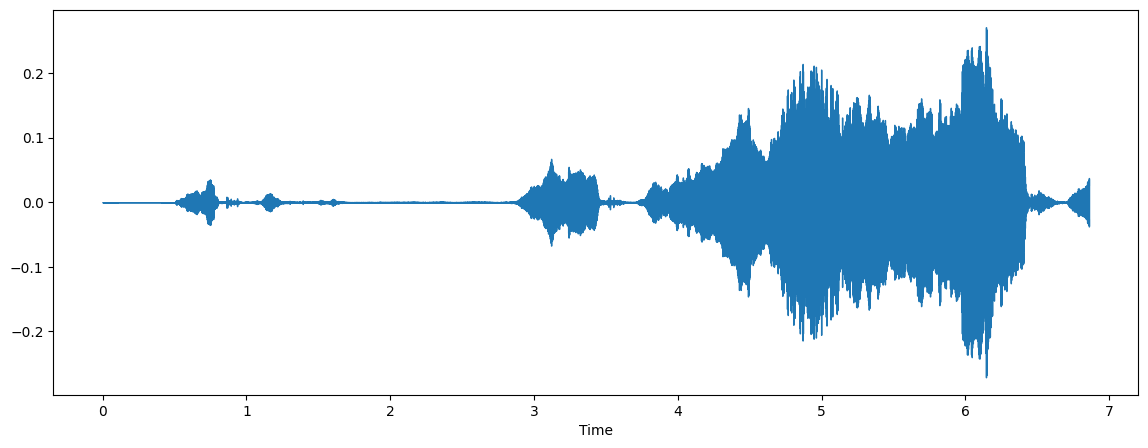

In [38]:
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(test)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(test)

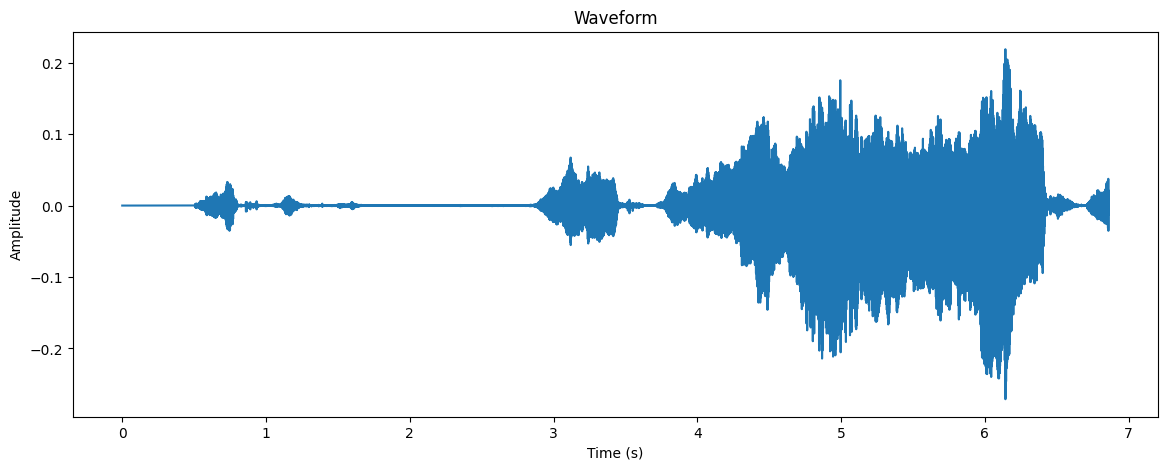

In [39]:
waveform, sr = librosa.load(test)
# Load the audio file
waveform, sr = librosa.load(test)

# Calculate the time array for x-axis
total_duration = len(waveform) / sr
time = np.linspace(0, total_duration, len(waveform))

# Display the waveform
plt.figure(figsize=(14, 5))
plt.plot(time, waveform)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

In [40]:
sample_rate

22050

In [41]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio=wav.read(test)

In [42]:
wave_sample_rate

8000

In [43]:
wave_audio

array([   0,    0,    0, ...,  385,   32, -202], dtype=int16)

In [44]:
data

array([ 1.1961961e-06,  1.5121070e-06,  2.1514887e-07, ...,
       -6.0190139e-03, -5.0411765e-03, -2.6009013e-03], dtype=float32)

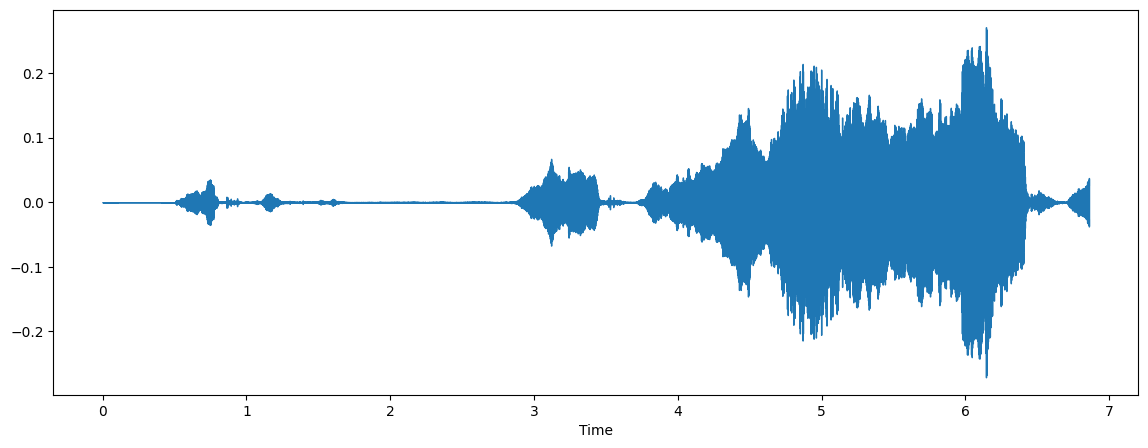

In [45]:
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(test)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(test)

In [46]:
librosa_audio_data,librosa_sample_rate=librosa.load(test)

In [47]:
print(librosa_audio_data)

[ 1.1961961e-06  1.5121070e-06  2.1514887e-07 ... -6.0190139e-03
 -5.0411765e-03 -2.6009013e-03]


In [48]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 296)


In [ ]:
def load_and_preprocess_audio(input_dataset_path, n_mfcc=13, sr=16000, target_samples=100, max_pad_len=200):

    desired_labels = ['hungry', 'discomfort', 'belly_pain', 'burping', 'tired']
    X, y = [], []  # Initialize X and y as lists

    def augment_audio(audio_data, sample_rate):
        # Time stretch
        audio_stretch = librosa.effects.time_stretch(audio_data, rate=np.random.uniform(0.8, 1.2))
        # Pitch shift
        audio_pitch = librosa.effects.pitch_shift(audio_data, sr=sample_rate, n_steps=np.random.uniform(-2, 2))
        return [audio_stretch, audio_pitch]

    for label in desired_labels:
        class_dir = os.path.join(input_dataset_path, label)
        class_samples = []

        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found for label '{label}'. Skipping.")
            continue

        for filename in os.listdir(class_dir):
            file_path = os.path.join(class_dir, filename)
            try:
                audio_data, sample_rate = librosa.load(file_path, sr=sr) 
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                continue

            # Noise reduction
            audio_data = nr.reduce_noise(y=audio_data, sr=sample_rate)

            # Silence removal
            audio_data, _ = librosa.effects.trim(audio_data)

            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)

            # Pad or truncate MFCCs to have uniform length
            if mfccs.shape[1] < max_pad_len:
                mfccs = np.pad(mfccs, ((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]

            class_samples.append(mfccs.T)

            # Augment audio
            if len(class_samples) < target_samples:
                for augmented_audio in augment_audio(audio_data, sample_rate):
                    aug_mfccs = librosa.feature.mfcc(y=augmented_audio, sr=sample_rate, n_mfcc=n_mfcc)

                    
                    if aug_mfccs.shape[1] < max_pad_len:
                        aug_mfccs = np.pad(aug_mfccs, ((0, 0), (0, max_pad_len - aug_mfccs.shape[1])), mode='constant')
                    else:
                        aug_mfccs = aug_mfccs[:, :max_pad_len]

                    class_samples.append(aug_mfccs.T)
                    if len(class_samples) >= target_samples:
                        break

            if len(class_samples) >= target_samples:
                break

        # Adjust the number of samples to target
        if len(class_samples) < target_samples:
            # Upsample
            class_samples = resample(class_samples,
                                     n_samples=target_samples,
                                     random_state=42)
        elif len(class_samples) > target_samples:
            # Downsample
            class_samples = resample(class_samples,
                                     n_samples=target_samples,
                                     random_state=42)

        X.extend(class_samples)  # To add multiple samples
        y.extend([label] * len(class_samples))

    return np.array(X), np.array(y)

# Usage
input_dataset_path = 'donateacry_corpus'
X, y = load_and_preprocess_audio(input_dataset_path, target_samples=100)


In [50]:
from collections import Counter

print(Counter(y))

Counter({'hungry': 100, 'discomfort': 100, 'belly_pain': 100, 'burping': 100, 'tired': 100})


In [51]:
# Print the class distribution
from collections import Counter
print("Class distribution:", Counter(y))

# Print the shape of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Print unique labels
print("Unique labels:", np.unique(y))

Class distribution: Counter({'hungry': 100, 'discomfort': 100, 'belly_pain': 100, 'burping': 100, 'tired': 100})
Shape of X: (500, 200, 13)
Shape of y: (500,)
Unique labels: ['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']


In [52]:
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [53]:
y_encoded

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [54]:
# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.4, random_state=42)

In [55]:
# Reshape data for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [56]:
# Step 7: Define the model
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=X_train.shape[1:]),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 198, 11, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 196, 9, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 98, 4, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 98, 4, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,230,853 (12.32 MB)

 Trainable params: 3,230,853 (12.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 8: Compile model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
checkpointer = ModelCheckpoint(filepath='saved_models/infant_audio_classification.keras',
                               verbose=1, monitor = 'val_accuracy', mode = 'max', save_best_only=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks = [checkpointer],
                    verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.1961 - loss: 140.4630
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to saved_models/infant_audio_classification.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 551ms/step - accuracy: 0.1947 - loss: 140.3216 - val_accuracy: 0.2500 - val_loss: 24.3885
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2584 - loss: 23.3396 
Epoch 2: val_accuracy improved from 0.25000 to 0.46667, saving model to saved_models/infant_audio_classification.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2639 - loss: 22.5355 - val_accuracy: 0.4667 - val_loss: 1.5787
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4262 - loss: 1.9076 
Epoch 3: val_accuracy improved from 0.46667 to 0.58333, saving model to saved_models/infant_audio_classification.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4307 - loss: 1.8706 - val_accuracy: 0.5833 - val_loss: 1.0917
Epoch 4/20
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

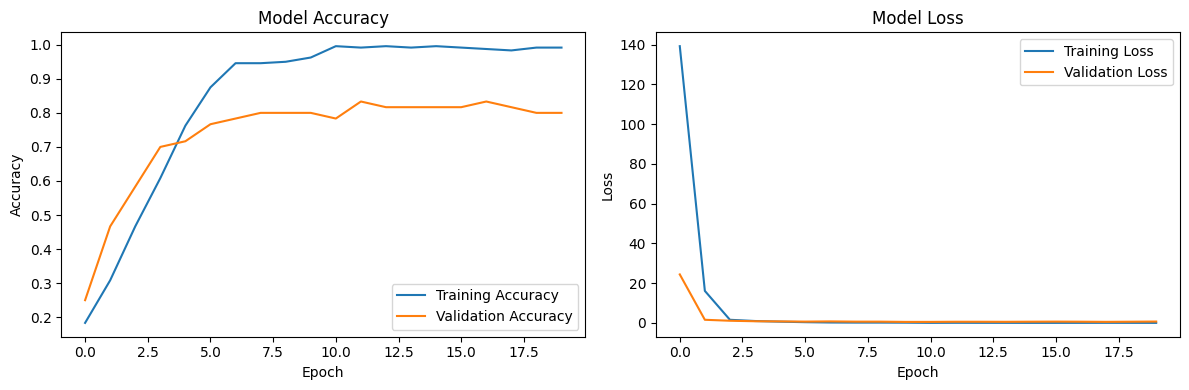

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [62]:
from sklearn.metrics import classification_report

print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

              precision    recall  f1-score   support

  belly_pain       0.80      0.90      0.85        31
     burping       0.97      1.00      0.99        39
  discomfort       0.68      0.74      0.71        38
      hungry       0.75      0.66      0.70        50
       tired       0.82      0.79      0.80        42

    accuracy                           0.81       200
   macro avg       0.81      0.82      0.81       200
weighted avg       0.80      0.81      0.80       200



In [60]:
# Step 10: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy}")

7/7 - 1s - 112ms/step - accuracy: 0.8050 - loss: 0.7063
Test Accuracy: 0.8050000071525574
